# Hack the STOP Sign for HITCON Pacific 2017
Code derived from tomaszkacmajor's [CarND-Traffic-Sign-Classifier-P2](https://github.com/tomaszkacmajor/CarND-Traffic-Sign-Classifier-P2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from scipy import ndimage
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.image as mpimg

# Visualizations will be shown in the notebook.
get_ipython().magic('matplotlib inline')

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [53]:
def grayscale(img):    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)[:,:,None]

def normalize(value):
    return value / 255 * 2 - 1

def preprocess_image(image):
    img = grayscale(image)
    img = normalize(img)
    return img

with open('signnames.csv') as csvfile:
    next(csvfile) # ignore header
    a = [ row.strip().split(',') for row in csvfile]
    signnames_dict = dict((data[0],data[1:]) for data in a)

### Model Architecture

In [3]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 200
BATCH_SIZE = 128
image_depth = 1
n_classes = 43

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, image_depth, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
        
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


x = tf.placeholder(tf.float32, (None, 32, 32, image_depth))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.003

logits = LeNet(x)

varss = tf.trainable_variables() 
lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in varss
                    if '_b' not in v.name ]) * 0.0001

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy) + lossL2
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)



correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

## Test on a real stop sign

Source: https://en.wikipedia.org/wiki/Stop_sign#/media/File:STOP_sign.jpg photo courtesy to Bidgee.

INFO:tensorflow:Restoring parameters from ./lenet
Predicted Labels: 14 ['Stop']


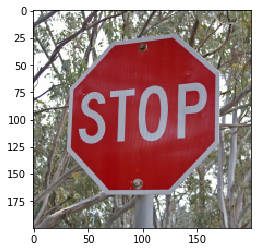

In [4]:
image = mpimg.imread('./STOP_sign.jpg')
image_to_show = cv2.resize(image, (200, 200), interpolation = cv2.INTER_AREA)
image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_AREA)
image = preprocess_image(image) 

test_images = [image,]
test_images = np.array(test_images)
test_responses = [0, ]
pred_val = tf.argmax(logits, 1)
pred_softmax = tf.nn.softmax(logits)
pred_topFive = tf.nn.top_k(pred_softmax, k=5)
plt.imshow(image_to_show)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    pred_val_out, pred_topFive_out = sess.run( [pred_val, pred_topFive], feed_dict={x:  test_images, y: test_responses})
    
v = pred_val_out[0]
print("Predicted Labels: %d %s" % (v, signnames_dict[str(v)] ))

## Try stop signs from Etimov et al. (2017)

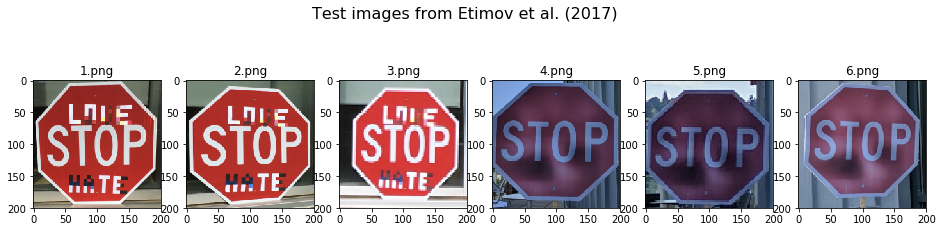

In [31]:
import os
img_folder = '../fake-stop-signs/' 
test_images = []
test_responses = [14, 14, 14, 14, 14, 14]
fig = plt.figure(figsize=(16,4))
fig.suptitle('Test images from Etimov et al. (2017)', fontsize=16)

cnt = 0
for img_name in os.listdir(img_folder):
    image = mpimg.imread(img_folder+img_name)
    image_to_show = cv2.resize(image, (200, 200), interpolation = cv2.INTER_AREA)
    image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_AREA)
    cnt = cnt+1
    sub=plt.subplot(1,6,cnt)
    sub.set_title(img_name)
    plt.imshow(image_to_show)
    image = preprocess_image(image) 
    test_images.append(image)
    
test_images = np.array(test_images)

In [33]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred_val_out, pred_topFive_out = sess.run( [pred_val, pred_topFive], feed_dict={x:  test_images, y: test_responses})
    
print("Predicted Labels")
print(pred_val_out)
print()

for (i, j) in zip(pred_val_out, test_responses):
    print("%d - %s -> %s" % (i, signnames_dict[str(i)], "Correct" if i == j else "Not correct!"))

INFO:tensorflow:Restoring parameters from ./lenet


INFO:tensorflow:Restoring parameters from ./lenet


Predicted Labels
[5 5 5 5 5 5]

5 - ['Speed limit (80km/h)'] -> Not correct!
5 - ['Speed limit (80km/h)'] -> Not correct!
5 - ['Speed limit (80km/h)'] -> Not correct!
5 - ['Speed limit (80km/h)'] -> Not correct!
5 - ['Speed limit (80km/h)'] -> Not correct!
5 - ['Speed limit (80km/h)'] -> Not correct!


In [65]:
color_pallettes = [
    (0, 152, 116, 0),   # emerald
    (221, 65, 36, 0),   # tangerine tango
    (214, 80, 118, 0), # honeysuckle
    (68, 184, 172, 0), # turquoise
    (239, 192, 80, 0), # mimosa
    (91, 94, 166, 0),    # blue izis
    (155, 35, 53, 0),    # chilli pepper
    (223, 207, 190, 0), # sand dollar
    (85, 180, 176, 0),   # blue turquoise
    (225, 93, 68, 0),    # tigerlily
    (127, 205, 205, 0), # aqua sky
    (188, 36, 60, 0),     # true red
    (195, 68, 122, 0),  # fuchsia rose
    (152, 180, 212, 0), # cerulean blue
    ]
rgb = [(255,0,0), (0,255,0), (0,0,255)]

INFO:tensorflow:Restoring parameters from ./lenet


INFO:tensorflow:Restoring parameters from ./lenet


Hacked in iteration 791
Predicted Labels: 39 ['Keep left'] (confidence = 58%)
Predictions:
	39 - ['Keep left']
	14 - ['Stop']
	13 - ['Yield']
	12 - ['Priority road']
	8 - ['Speed limit (120km/h)']


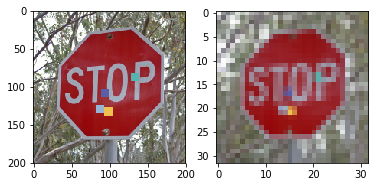

In [69]:
from random import randrange, choice

image = mpimg.imread('./STOP_sign.jpg')
im = cv2.resize(image, (200, 200), interpolation = cv2.INTER_AREA)

# Stick posters within the rectangle of (50, 150, 50, 150)
sticker_width = 10
sticker_height = 10
number_of_trials = 1000
number_of_stickers = 4

test_images = []
test_responses = []
sticked_images = []

for i in range(number_of_trials):
    newim = im.copy()
    for _ in range(number_of_stickers):
        rec_x = randrange(50, 150)
        rec_y = randrange(50, 150)
        color = choice(color_pallettes)
        cv2.rectangle(newim, (rec_x, rec_y), (rec_x+sticker_width, rec_y+sticker_height), color, -1)
    image = cv2.resize(newim, (32, 32), interpolation = cv2.INTER_AREA)
    test_images.append(preprocess_image(image))
    test_responses.append(14)
    sticked_images.append(newim)

pred_val = tf.argmax(logits, 1)
pred_softmax = tf.nn.softmax(logits)
pred_topFive = tf.nn.top_k(pred_softmax, k=5)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred_val_out, pred_topFive_out = sess.run( [pred_val, pred_topFive], feed_dict={x: test_images, y: test_responses})

for i in range(number_of_trials):
    if pred_val_out[i] != 14:
        print('Hacked in iteration %d' % i)
        plt.subplot(1, 2, 1)
        plt.imshow(sticked_images[i])
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.resize(sticked_images[i], (32, 32), interpolation = cv2.INTER_AREA))
        print("Predicted Labels: %d %s (confidence = %d%%)" %
              (pred_val_out[i], signnames_dict[str(pred_val_out[i])], pred_topFive_out.values[i][0]*100))
        print("Predictions:")
        for label in pred_topFive_out.indices[i]:
            print('\t%d - %s' % (label, signnames_dict[str(label)]))
        break
else:
    plt.imshow(sticked_images[0])
    print('Guess more!')